# Preliminary support for predictive coding  

If inhibitory interneurons subtract a prediction of ganglion firing, we should expect higher correlations between the ganglion cells and connected inhibitory interneurons if we were able to silence inhibitory communication to the ganglion cells (but not alter the inhibitory membrane potential).  

We can essentially do this with intracellular record & playback experiments. This notebook will analyze some of David Kastner's record & playback data to determine if the correlations between ganglion cells and amacrine cells is what we'd expect when inhibition is amplified or diminished.

In [110]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import sem, pearsonr
import scipy.io
import itertools
import os
import h5py
import pyret
import binary     # in igor >> recording

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
from matplotlib.pyplot import *

# note that nonposx(y) for log plots will no longer work with this package
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_dir = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Predictive Coding Correlation Experiments/')

### Load ganglion cell spiking and inhibitory interneuron membrane potential  
ganglion is cell array of which playback experiment (0,1,2) >> which cell (0, ..., 13) >> which spike timestamp  
surround is cell array of which playback experiment (0,1,2) >> membrane potential

In [3]:
ganglion_files = ['012514_ganglions_0.mat','012514_ganglions_1.mat','012514_ganglions_2.mat']
surround_files = ['012514_c1_s0_0_300.txt','012514_c1_s1_0_300.txt','012514_c1_s2_0_300.txt']

ganglion = []
surround = []

# load ganglion cell spiking files
for g_file in ganglion_files:
    tmp = scipy.io.loadmat(data_dir + g_file, squeeze_me=True)
    cells = [tmp['spikes'][:,c][tmp['spikes'][:,c] > 0] for c in range(tmp['spikes'].shape[1])]
    ganglion.append(cells)
    
# load surround membrane potential
for s_file in surround_files:
    tmp = np.loadtxt(data_dir + s_file, dtype='float', skiprows=1)
    surround.append(tmp)

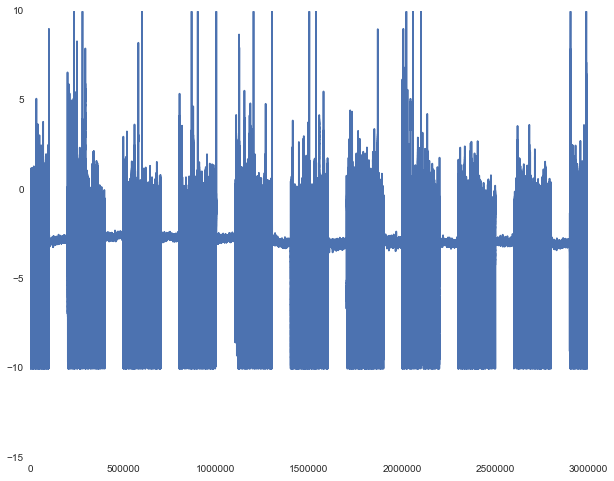

In [4]:
plot(surround[0])

## Copy Table0:info conditions information 

### According to conversation with David, 0-1 is control, 2-3 is amplify, and 4-5 is diminish for 1/25/14 experiment, whereas 0-1 is control, 2-3 is diminish, 4-5 is amplify for 4/4/12 experiment.  

### From the firing rate plot below however, it must always be 0-1 control, 2-3 diminish, 4-5 amplify.

In [62]:
control_time = [[10.5, 20.], [0.5, 10.], [20.5, 30.]]
amplify_time = [[0.5, 10.], [20.5, 30.], [10.5, 20.]]
diminish_time = [[20.5, 30.], [10.5, 20.], [0.5, 10.]]

# Look at ganglion firing rates in the amplify, diminish, and control conditions

In [63]:
num_seconds = 0.95*300./3
control_firing_rate = []
amplify_firing_rate = []
diminish_firing_rate = []
for idp, playback in enumerate(ganglion):
    for idc, cell in enumerate(playback):
        ctrl = [spike for spike in cell if spike % 30 > control_time[idp][0] and spike % 30 < control_time[idp][1]]
        amp  = [spike for spike in cell if spike % 30 > amplify_time[idp][0] and spike % 30 < amplify_time[idp][1]]
        dim  = [spike for spike in cell if spike % 30 > diminish_time[idp][0] and spike % 30 < diminish_time[idp][1]]
        control_firing_rate.append(len(ctrl)/num_seconds)
        amplify_firing_rate.append(len(amp)/num_seconds)
        diminish_firing_rate.append(len(dim)/num_seconds)
        
firing_rates = np.array([control_firing_rate, amplify_firing_rate, diminish_firing_rate]).T
cell_means   = np.mean(firing_rates, axis=1)
relative_firing_rates = 100. * ((firing_rates.T - cell_means)/cell_means).T # percent firing increase/decrease

## All firing rates

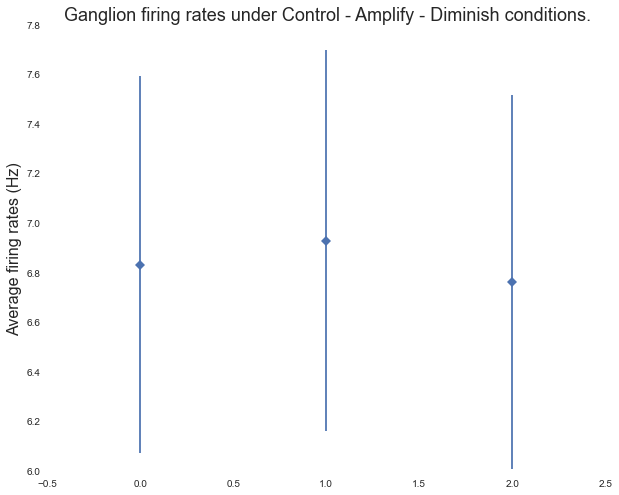

In [71]:
frs = [np.mean(control_firing_rate), np.mean(amplify_firing_rate), np.mean(diminish_firing_rate)]
sems = [sem(control_firing_rate), sem(amplify_firing_rate), sem(diminish_firing_rate)]
errorbar([0,1,2], frs, yerr=sems, fmt='D')
xlim([-.5, 2.5])
title('Ganglion firing rates under Control - Amplify - Diminish conditions.', fontsize=18)
ylabel('Average firing rates (Hz)', fontsize=16)

# Average increase/decrease in relative firing rates

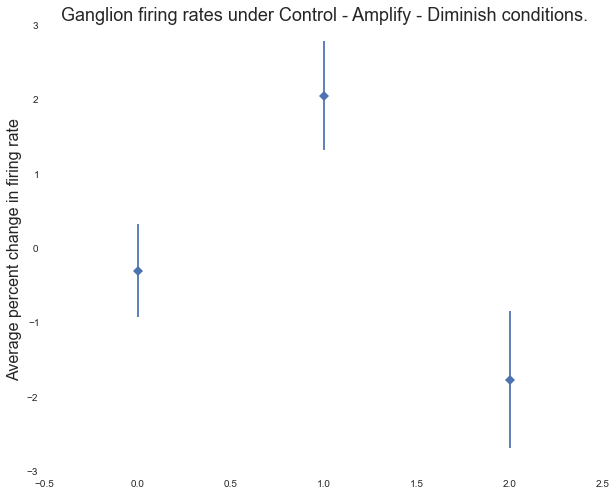

In [73]:
frs = np.mean(relative_firing_rates, axis=0)
sems = sem(relative_firing_rates)
errorbar([0, 1, 2], frs, yerr=sems, fmt='D')
xlim([-.5, 2.5])
title('Ganglion firing rates under Control - Amplify - Diminish conditions.', fontsize=18)
ylabel('Average percent change in firing rate', fontsize=16)

# Compute correlations

## Correlations:  
- Control ganglion cell & control amacrine cell  
- Diminished ganglion cell & control amacrine cell  
- Amplified ganglion cell & control amacrine cell  

Need to control for visual stimulus, so will need to compute correlation across different 300s playback trials

In [83]:
sample_rate = len(surround[0])/300.
block_time = np.linspace(0,9.5,9.5 * sample_rate)    # time per trial subblock
trial_time = np.linspace(0,300,len(surround[0]))

### Correlation between control and control (this has to be within-trial)

In [114]:
control_control_corrs = []
for playback in range(3):
    # make list of 0's and 1's corresponding to if in a control period
    ctrl_inds = [ind for ind,t in enumerate(trial_time) if t % 30 > control_time[playback][0] and t % 30 < control_time[playback][1]]
    ctrl_inhibition = surround[playback][ctrl_inds]
    
    for cell in ganglion[playback]:
        # make list of 0's and 1's corresponding to if cell spiked in that time window
        spiking, tax = pyret.spiketools.binspikes(cell, time=trial_time)
        
        # get only the spiking behavior during the control sequences
        ctrl_spiking = spiking[ctrl_inds]
        
        # store correlations between control ganglion cell and control amacrine cell
        control_control_corrs.append(pearsonr(ctrl_inhibition, ctrl_spiking)[0])

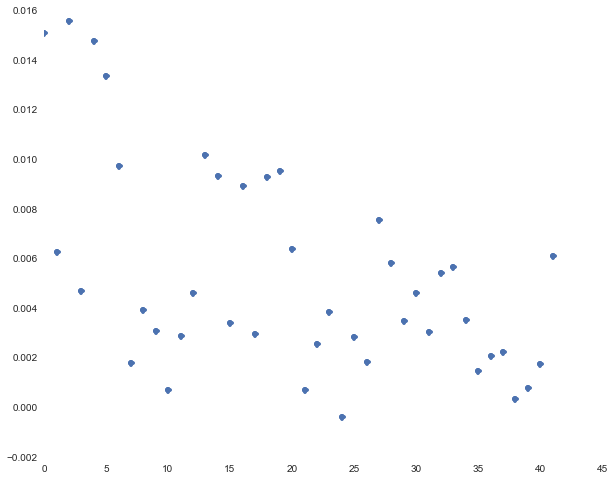

In [115]:
plot(control_control_corrs, 'o')

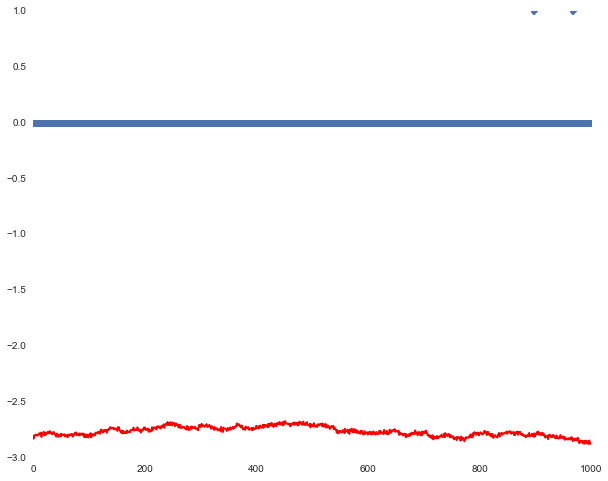

In [116]:
plot(ctrl_spiking[:1000], 'o')
plot(ctrl_inhibition[:1000], 'r')

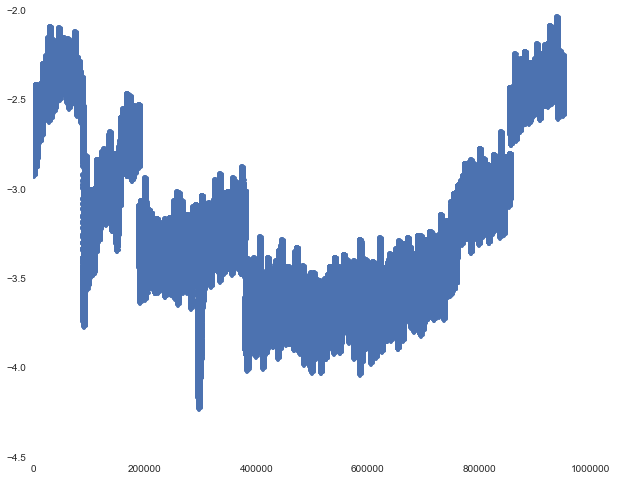

In [118]:
plot(ctrl_inhibition, 'o')